# Quadratic discriminant analysis

## Introduction

In this model we will explore the Quadratic Discriminant Analysis (QDA) algorithm. The basis of the model is essentially the same as of the Linear Discriminant Analysis, and the details about it as well as the implementation can be seen in [this](https://github.com/felperez/machine-learning/blob/master/10.%20Linear%20discriminant%20analysis.ipynb) previous notebook.

## The model

As mentioned before, the model for QDA is similar to LDA. Suppose we are given observations  $\{(x_1,y_1),\dots,(x_m,y_m)\}\subset \mathbb{R}^n\times F$ where $F$ is a finite set (which we will identify with $\{0,\dots,K-1 \}$, where $k=\# F$). For each class $j$, we have a prior probability $\pi_j$ (so $\sum_j \pi_j = 1$) representing the probability that a randomly sampled observation comes from the class $j$.  We will assume that the conditional density of $X$ for each class is Gaussian, with covariance matrix $\Sigma_k$ for each class $k$:
$$
p(x \ | \ y = k) = \dfrac{1}{(2\pi)^{n/2}|\Sigma_k|^{1/2}}\exp(-\dfrac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k))
$$
where $\mu_k$ is the mean of each class. Let $x\in\mathbb{R}^n$ be a point for which we want to predict the class $y$ it belongs to. By the Bayes theorem
$$
\mathbb{P}(y = k \ | \ x) = \dfrac{p(x \ | \ y = k)\pi_k}{\sum_{i=0}^{K-1}p(x \ | \ y = i)\pi_i  }.
$$
The Bayes discriminant rules predicts $y=k$ for the value of $k$ that maximizes $\mathbb{P}(y = k \ | \ x) $. Note that the denominator is common for all classes, so in practice we maximize $p(x \ | \ y = k)\pi_k$. In order to do so, denote $k^* = \mathrm{argmax}_k\mathbb{P}(y = k \ | \ x) $ and note that is equivalent to
$$
k^* = \underset{k}{\mathrm{argmax}} \log\left(  \dfrac{\mathbb{P}(y = k \ | \ x) }{\mathbb{P}(y = i \ | \ x) } \right)
$$
where the maximum is taken with respect to $k$ and $i$. Since we know the conditional density of each class, we can compute the above expression explicitly:
$$
\log\left(  \dfrac{\mathbb{P}(y = k \ | \ x) }{\mathbb{P}(y = i \ | \ x) } \right) =  \delta_k(x) - \delta_i(x),
$$
where $\delta_{k}(x)=\log \pi_k -\dfrac{1}{2} (x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k) - \dfrac{1}{2}\log|\Sigma_k|$. Note then that $k^* = \underset{k}{\mathrm{argmax\ }} \delta_k(x)$. Now, in order to solve this optimization problem, we need $\pi_k$ $\mu_k$ and $\Sigma$. Since we do not know in advance these values, we can estimate them using our training data. We use the following estimators:

$
\begin{align}
\hat{\pi}_k &= \dfrac{\#\{ i : y_i = k\}}{m} \\
\hat{\mu_k}& = \dfrac{1}{\#\{ i : y_i = k\}}\sum_{y_i=k} x_i \\
\hat{\Sigma_k}&=\dfrac{1}{K-1}\sum_{y_i=k}(x_i-\hat{\mu}_k)(x_i-\hat{\mu}_k)^T.
\end{align}
$
With this, we can implement the algorithm:

## Implementation of the algorithm

We start by importing the usual libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We generate three clouds of points with Gaussian distribution conditional to their classes. We assume each class has its own covariance matrix:

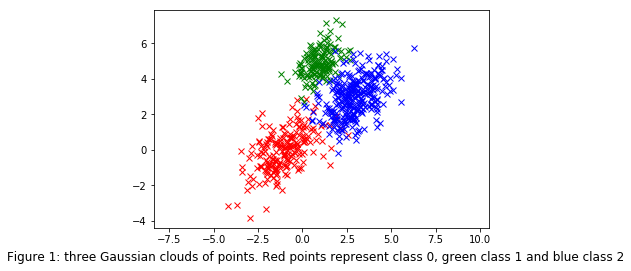

In [2]:
x0 = np.random.multivariate_normal([-1, 0], [[1.35, 0.75],[0.75, 1.35]], 200)
x1 = np.random.multivariate_normal([1, 5], [[0.6, .25],[.25, 0.6]], 150)
x2 = np.random.multivariate_normal([3, 3], [[1, .35],[.35, 1]], 300)

plt.plot(x0[:,0],x0[:,1],'x',color='red')
plt.plot(x1[:,0],x1[:,1],'x',color='green')
plt.plot(x2[:,0],x2[:,1],'x',color='blue')
plt.figtext(0.5, 0.01, 'Figure 1: three Gaussian clouds of points. Red points represent class 0, green class 1 and blue class 2', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.axis('equal')
plt.show()

We assign labels to each of the points and generate a matrix containing the observations and a vector containing the labels:

In [3]:
y0 = np.zeros(len(x0))
y1 = np.ones(len(x1))
y2 = 2*np.ones(len(x2))

X_train =  np.vstack((x0,x1,x2))
Y_train = np.append(np.append(y0,y1),y2)

We estimate the priori probabilities $\pi_k$ of each class:

In [4]:
def priors(X_train,Y_train):
    priors_list = []
    for i in np.unique(Y_train):
        priors_list.append(sum(Y_train == i)/len(Y_train))
    return priors_list

We compute now the sample mean of each class:

In [5]:
def means(X_train,Y_train):
    W = np.hstack((X_train,Y_train.reshape(-1,1)))
    means_list = []
    for i in np.unique(Y_train):
        means_list.append(np.mean(X_train[W[:,-1] == i],axis=0))
    return means_list

We compute now the sample covariance matrices $\Sigma_k$ for each class. We use the numpy built-in function:

In [6]:
def covariances(X_train,Y_train):
    W = np.hstack((X_train,Y_train.reshape(-1,1)))
    cov_list = []
    for i in np.unique(Y_train):
        cov_list.append(np.cov(X_train[W[:,-1] == i].T))
    return cov_list

We compute the inverses of each covariance matrix:

In [7]:
def inv_cov(sigma):
    return np.linalg.inv(sigma)

With this we can construct the decision functions $\delta_k(x):$

In [8]:
def delta(mu,sigma,inv_sigma,prior,k,x):
    return (np.log(prior[k]) - (1/2)*np.dot(np.dot((x-mu[k]).reshape(-1,1).T,inv_sigma[k]),(x-mu[k])) 
            - (1/2)*np.log(np.abs(np.linalg.det(sigma[k]))))

And finally, the prediction function:

In [9]:
def prediction(mu,sigma,inv_sigma,prior,x):
    L = []
    for k in range(len(sigma)):
        L.append( delta(mu,sigma,inv_sigma,prior,k,x))
    return np.argmax(L)

We put everything together in a function that gives us the 

In [10]:
class QDA:    
    def __init__(self):
        self.prior = []
        self.means = []
        self.covar = []
        self.inverses = []
    
    def fit(self,X_train,Y_train):
        self.prior = priors(X_train,Y_train)
        self.means = means(X_train,Y_train)
        self.covar = covariances(X_train,Y_train)
        self.inverses = inv_cov(self.covar)
    
    def pred(self,x):
        return prediction(self.means,self.covar,self.inverses,self.prior,x)

With this we can plot the decision boundary as well as the prediction for each point of the plane:

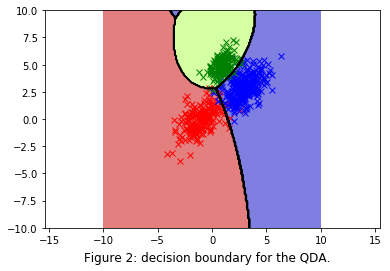

In [11]:
model = QDA()
model.fit(X_train,Y_train)

x = np.linspace(-10, 10, 200)
y = np.linspace(-10, 10, 200)
X, Y = np.meshgrid(x, y)
z = np.zeros(X.shape)
Z = np.array(z)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i,j] = model.pred(np.array([x[j],y[i]]))
plt.contourf(X, Y, Z, alpha=.5, cmap='jet_r')
C = plt.contour(X, Y, Z,  colors='black',zorder=4)
plt.plot(x0[:,0],x0[:,1],'x',color='red',zorder=1)
plt.plot(x1[:,0],x1[:,1],'x',color='green',zorder=3)
plt.plot(x2[:,0],x2[:,1],'x',color='blue',zorder=2)
plt.axis('equal')
plt.figtext(0.5, 0.01, 'Figure 2: decision boundary for the QDA.', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

We can see now how the algorithm behaves in a different situation:

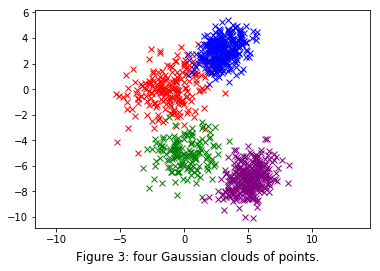

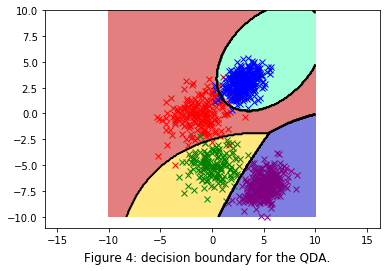

In [12]:
xx0 = np.random.multivariate_normal([-1, 0], [[2.35, 0.75],[0.75, 2.35]], 200)
xx1 = np.random.multivariate_normal([0, -5], [[1.6, .25],[.25, 1.6]], 150)
xx2 = np.random.multivariate_normal([3, 3], [[1, .35],[.35, 1]], 300)
xx3 = np.random.multivariate_normal([5, -7], [[1, .35],[.35, 1]], 300)

plt.plot(xx0[:,0],xx0[:,1],'x',color='red')
plt.plot(xx1[:,0],xx1[:,1],'x',color='green')
plt.plot(xx2[:,0],xx2[:,1],'x',color='blue')
plt.plot(xx3[:,0],xx3[:,1],'x',color='purple')
plt.figtext(0.5, 0.01, 'Figure 3: four Gaussian clouds of points.', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.axis('equal')
plt.show()

yy0 = np.zeros(len(x0))
yy1 = np.ones(len(x1))
yy2 = 2*np.ones(len(x2))
yy3 = 3*np.ones(len(x2))

X_train =  np.vstack((xx0,xx1,xx2,xx3))
Y_train = np.vstack((yy0.reshape(-1,1),yy1.reshape(-1,1),yy2.reshape(-1,1),yy3.reshape(-1,1)))


model = QDA()
model.fit(X_train,Y_train)


x = np.linspace(-10, 10, 200)
y = np.linspace(-10, 10, 200)
X, Y = np.meshgrid(x, y)
z = np.zeros(X.shape)
Z = np.array(z)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i,j] = model.pred(np.array([x[j],y[i]]))
plt.contourf(X, Y, Z, alpha=.5, cmap='jet_r')
C = plt.contour(X, Y, Z,  colors='black',zorder=4)
plt.plot(xx0[:,0],xx0[:,1],'x',color='red',zorder=1)
plt.plot(xx1[:,0],xx1[:,1],'x',color='green',zorder=3)
plt.plot(xx2[:,0],xx2[:,1],'x',color='blue',zorder=2)
plt.plot(xx3[:,0],xx3[:,1],'x',color='purple',zorder=2)
plt.axis('equal')
plt.figtext(0.5, 0.01, 'Figure 4: decision boundary for the QDA.', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

## Final remarks

In future notebooks we will explore the stability of QDA as well as LDA and its performance compared to Naive Bayes algorithms.